In [1]:
%load_ext autoreload
%autoreload 2

This test illustrates that in the case of total uncorrelation, the posterior with is determined by prior (std 1) and likelihood (std 1).

In [2]:
import numpy as np
import torch
from torch import nn
import torch
import time
from pytorch_unet.unet import UNet  # Run "git clone https://github.com/cweniger/pytorch_unet.git"
import swyft
import pylab as plt
import scipy.stats.distributions as dist
from tqdm import tqdm

torch.set_float32_matmul_precision('medium')
DEVICE = "cuda"

In [6]:
SIGMA = 1
NPIX = 64

### Generative model

In [7]:
class SimulatorBlob(swyft.Simulator):
    def __init__(self, bounds = None, Npix = NPIX, sigma = SIGMA, bounds_theta = None):
        super().__init__()
        self.transform_samples = swyft.to_numpy32
        self.bounds = bounds
        self.Npix = Npix
        self.sigma = sigma
        self.powersampler = swyft.utils.PowerSpectrumSampler(Npix)
        self.sigma = torch.ones(Npix, Npix)*sigma

    def get_pk_fn(self):
        #return lambda k: torch.where(k<2, 10000, .00000001)
        #return lambda k: 1e4*3*(k/0.5+1)**-4
        return lambda k: k*0 + 2  # pixel std is 1

    def sample_delta(self, pk_fn):
        if self.bounds:
            i = np.random.randint(len(self.bounds))
            return torch.tensor(self.bounds[i])
        else:
            return self.powersampler.sample(pk_fn)
            
    def build(self, graph):
        pk_fn = graph.node("pk_fn", self.get_pk_fn)
        delta = graph.node("delta", self.sample_delta, pk_fn)
        x = graph.node("x", lambda delta: delta + torch.randn(self.Npix, self.Npix)*self.sigma, delta)

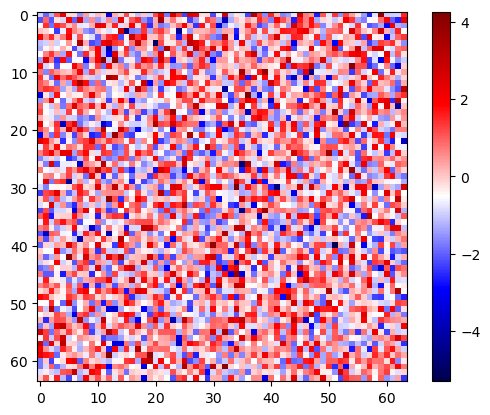

(-0.018324554, 1.4154819)

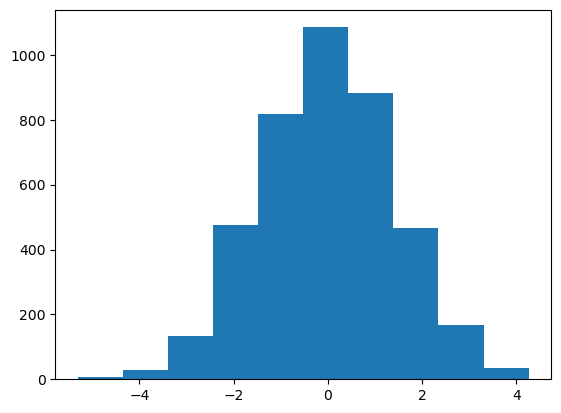

In [8]:
sim = SimulatorBlob(Npix = NPIX, sigma = SIGMA)
sample0 = sim.sample()
del sample0['pk_fn']
plt.imshow(sample0['x'], cmap = 'seismic')#, vmin = - 20, vmax = 20)
plt.colorbar()
plt.show()
plt.hist(sample0['x'].flatten());
sample0['x'].mean(), sample0['x'].std()

### Inference network

In [9]:
class Network_delta_x(swyft.SwyftModule):
    def __init__(self, N = NPIX):
        super().__init__()
        self.learning_rate = 1e-3
        self.N = N
        L = lambda x: x*0
        self.Phi = lambda x: x
        self.PhiT = lambda x: x
        self.lre = swyft.LogRatioEstimator_Gaussian_Autoregressive_X_module_based(
            self.N**2, "mu", Phi = self.Phi, PhiT = self.PhiT, L = L, minstd = 1e-5, momentum=0.02)
        self.unet = UNet(1, 1, hidden_channels = 16, shallow=True)
        self.norm1 = torch.nn.LazyBatchNorm2d(momentum = 0.01, affine = False)
    
    def embed(self, x):
        # Input normalization apparently degrades performance, even for small momentum settings.
       # x = self.norm1(x.unsqueeze(1)).squeeze(1)
        x = self.unet(x.unsqueeze(1)).squeeze(1)*0 + x
        x = x.view(-1, self.N**2)
        return x

    def forward(self, A, B):
        N = self.N
        try:
            rhoA = self.embed(A['x'])
            rhoB = self.embed(B['x'])
            deltaB = B['delta'].view(-1, N**2)
            result1 = self.lre(rhoA, rhoB, deltaB)
        except KeyError:
            result1 = None
        
        return result1

### Inference

In [10]:
def get_samples(n_sims = 3000, bounds = None):
    sim = SimulatorBlob(Npix = NPIX, bounds = bounds, sigma = SIGMA)
    samples = sim.sample(n_sims, exclude = ['pk_fn'])
    return sim, samples

In [11]:
def train_delta_x(samples, max_epochs = 5):
    dm = swyft.SwyftDataModule(samples, batch_size = 32)
    net = Network_delta_x()
    trainer = swyft.SwyftTrainer(accelerator = DEVICE, max_epochs = max_epochs)
    trainer.fit(net, dm)
    return trainer, net

def infer_delta_x(sample0, sim, trainer, net, n_draws = 10, gamma = 0.1, steps = 1000):
    GAMMA = gamma
    x = sample0['x']
    d = sample0['delta']
    y = net.cuda().double().embed(torch.tensor(x).cuda().double().unsqueeze(0))[0]
    draws = []
    x0s = []
    for _ in tqdm(range(n_draws)):
        pk = sim.sample()['pk_fn']
        prior = sim.powersampler.get_prior_Q_factors(pk)
        prior = (prior[0], prior[1].cuda(), prior[2])
        x0 = net.lre.get_MAP(y, prior, gamma = GAMMA)
        x0s.append(x0)
        draw = net.lre.get_noise_samples_GEDA(1, prior, steps = steps, reset = True, gamma = GAMMA)[0]
        draws.append(draw)
    draws = torch.stack(draws)
    x0s = torch.stack(x0s)
    
    bounds = [(x0s[i].view(NPIX, NPIX).cpu().detach() + draws[i].view(NPIX, NPIX).cpu()).numpy() for i in range(len(draws))]
    bounds = np.array(bounds)

    net.float()
    
    v = 15
    plt.figure(figsize = (15, 5))
    for i in range(4):
        plt.subplot(2, 4, i+1)
        if i == 0:
            plt.imshow(sample0['delta'], cmap = 'seismic', vmin = -v, vmax = v)
        else:
            plt.imshow(bounds[i], vmin = -v, vmax = v, cmap = 'seismic')
        plt.colorbar()    
    #res = [(x0.view(NPIX, NPIX).cpu().detach()*0 + draws[i].view(NPIX, NPIX).cpu()).numpy() for i in range(len(draws))]
    print(x.min(), x.max(), bounds[0].min(), bounds[0].max())
    res = [d - bounds[i] for i in range(len(draws))]
    for i in range(4):
        plt.subplot(2, 4, i+1+4)
        plt.imshow(res[i], vmin = -v, vmax = v, cmap = 'seismic')
        plt.colorbar()
    plt.show()

    x = sample0['delta'].flatten()  # Ground truth
    y = bounds.reshape(-1, NPIX**2)  # Posterior samples
    ym = y.mean(axis=0)
    ys = y.std(axis=0)
    plt.scatter(x, ym)
    plt.scatter(x, x)
    plt.show()

    diff = (ym-x).flatten()
    plt.hist(diff, bins = 30)
    plt.show()
    p = np.percentile(diff, [2.5, 16, 50, 84, 97.5])
    print("Residual percentiles:", p)
    print("Mean posterior std per pixel:", ys.mean())

    pks = swyft.utils.get_pk(torch.tensor(bounds))
    clean_sims = sim.sample(100)['delta']
    pks2 = swyft.utils.get_pk(torch.tensor(clean_sims))
    pks3 = swyft.utils.get_pk(torch.tensor(sample0['delta']))
    plt.plot([], '0.5', alpha = 0.5, label = "Unconstrained")
    plt.plot([], 'r', alpha = 0.5, label = "Constrained")
    plt.semilogy(pks2.T, '0.5', alpha = 0.5);
    plt.semilogy(pks.T, 'r', alpha = 0.5);
    plt.semilogy(pks3.T, 'y', label = "Truth");
    plt.legend()
    plt.show()  

    return bounds

## The analysis

In [12]:
bounds_delta_x = None

In [13]:
# Estimate delta from free x - round 4
sim, samples = get_samples(n_sims = 3000, bounds = bounds_delta_x)
trained_delta_x = train_delta_x(samples, max_epochs = 50)

  0%|          | 0/3000 [00:00<?, ?it/s]

/home/weniger/.conda/envs/lensing/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/home/weniger/.conda/envs/lensing/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/weniger/.conda/envs/lensing/lib/python3.9/site ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
/home/weniger/.con

Sanity Checking: 0it [00:00, ?it/s]

/home/weniger/.conda/envs/lensing/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 72 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/weniger/.conda/envs/lensing/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 72 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Reloading best model: /gpfs/home2/weniger/swyft/notebooks/dev/lightning_logs/version_3899281/checkpoints/epoch=1-step=150-v1.ckpt


100%|█████████████████████████████████████████| 100/100 [00:11<00:00,  8.46it/s]


-5.3055 4.2606416 -3.7138478879394388 3.547546266965425


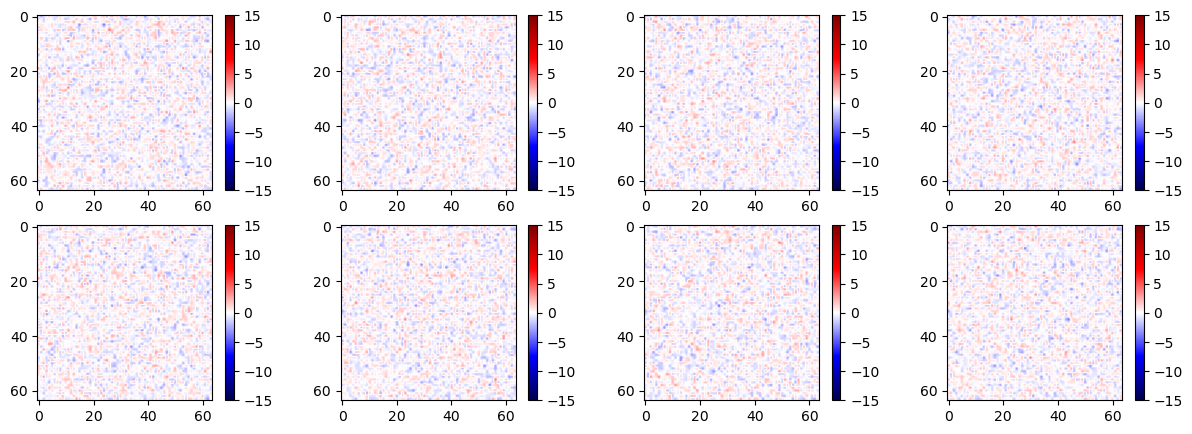

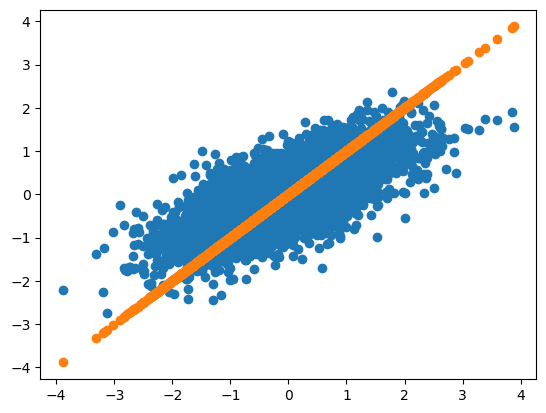

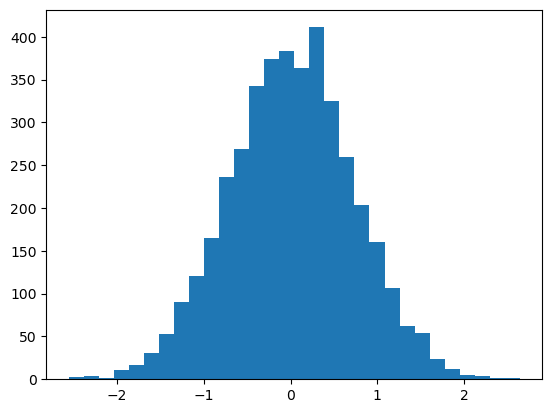

Residual percentiles: [-1.40648959 -0.69993426  0.01675263  0.72106119  1.42947551]
Mean posterior std per pixel: 0.695121390531917


  0%|          | 0/100 [00:00<?, ?it/s]

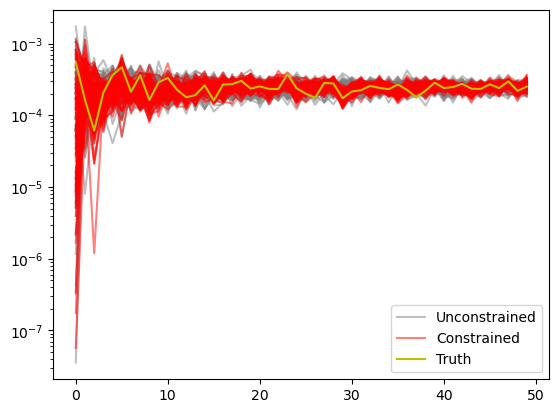

1

In [14]:
bounds_delta_x = infer_delta_x(sample0, sim, *trained_delta_x, n_draws = 100, gamma = 1e0, steps = 300)
SIGMA

In [15]:
1/2**0.5  # Expected variance

0.7071067811865475